In [39]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [40]:
# =========================================================
# ENSANUT 2023 - SOLO: CSVs + CATÁLOGOS + MAP (código→etiqueta)
# - Lee todos los CSV por componente
# - Lee catálogos (Variables/Valores) aunque no empiecen en A1
# - Construye maps: { variable -> { codigo: etiqueta } }
# - NO aplica mapeos ni construye matrices
# =========================================================

import re
import pandas as pd
from pathlib import Path
from openpyxl import load_workbook

# ---------- CONFIG ----------
BASE_DIR = Path("/content/drive/MyDrive/POSTDOCTORADO C3/ENSANUT/2023/ensanut_2023_ALL")
COMPONENTES = ["nutricion", "salud"]  # ajusta si quieres
CSV_SUBDIR = "csv"
CAT_SUBDIR = "catalogos"

# ---------- Utilidad: detectar fila de encabezados ----------
def find_header_row(ws, expected_headers, search_rows=200, search_cols=30, min_hits=2):
    """
    Escanea las primeras 'search_rows' x 'search_cols' celdas
    y retorna el número de fila (1-indexado) donde aparezcan al menos 'min_hits'
    encabezados esperados (texto coincidente exacto).
    """
    for r, row in enumerate(ws.iter_rows(min_row=1, max_row=search_rows, max_col=search_cols), start=1):
        vals = [str(c.value).strip() if c.value is not None else "" for c in row]
        hits = sum(1 for h in expected_headers if h in vals)
        if hits >= min_hits:
            return r
    return None

# ---------- Lectura robusta de catálogo ----------
def read_catalogo(path_xlsx):
    """
    Devuelve:
      - df_variables  (hoja 'Variables' o la primera)
      - df_valores    (hoja 'Valores' si existe, ya normalizada)
      - maps          dict { variable -> {codigo: etiqueta} }
      - has_valores   bool
    """
    wb = load_workbook(path_xlsx, read_only=True, data_only=True)
    names = wb.sheetnames

    # ---- Variables ----
    sheet_vars = "Variables" if "Variables" in names else names[0]
    ws_vars = wb[sheet_vars]
    hdr_vars = find_header_row(
        ws_vars,
        expected_headers=["Variable", "Posición", "Posicion", "Etiqueta", "Nivel", "Ancho"],
        min_hits=2
    )
    if hdr_vars is None:
        raise ValueError(f"No se halló encabezado en hoja '{sheet_vars}' de {path_xlsx}")

    df_variables = pd.read_excel(
        path_xlsx, sheet_name=sheet_vars, engine="openpyxl",
        header=0, skiprows=hdr_vars-1
    )

    # Normalizar nombres de columnas
    renv = {}
    for c in df_variables.columns:
        cl = str(c).strip().lower()
        if cl == "variable":                renv[c] = "variable"
        elif cl in ("posición","posicion"): renv[c] = "posicion"
        elif "tiqueta" in cl:               renv[c] = "etiqueta"
        elif "nivel" in cl:                 renv[c] = "nivel"
        elif "ancho" in cl or "width" in cl:renv[c] = "ancho"
    if renv:
        df_variables = df_variables.rename(columns=renv)

    if "variable" in df_variables.columns:
        df_variables["variable"] = df_variables["variable"].astype(str).str.strip()

    # ---- Valores (opcional) ----
    has_valores = "Valores" in names
    df_valores = pd.DataFrame(columns=["variable","codigo","etiqueta"])
    maps = {}

    if has_valores:
        ws_vals = wb["Valores"]
        hdr_vals = find_header_row(
            ws_vals,
            expected_headers=["Variable","Valor","Código","Codigo","Etiqueta","Descripción","Descripcion","Label"],
            min_hits=2
        )
        if hdr_vals is not None:
            raw_vals = pd.read_excel(
                path_xlsx, sheet_name="Valores", engine="openpyxl",
                header=0, skiprows=hdr_vals-1
            )

            # Normalizar columnas típicas a: variable / codigo / etiqueta
            ren = {}
            for c in raw_vals.columns:
                cl = str(c).strip().lower()
                if cl in ("variable", "valor"):                            ren[c] = "variable"
                elif cl in ("código","codigo","code","valor","unnamed: 1"): ren[c] = "codigo"
                elif ("tiqueta" in cl) or ("label" in cl) or ("descrip" in cl):
                    ren[c] = "etiqueta"

            keep = [k for k in ["variable","codigo","etiqueta"] if k in set(ren.values())]
            if keep:
                df_valores = raw_vals.rename(columns=ren)[keep].copy()

                # Limpiar types
                if "variable" in df_valores:
                    df_valores["variable"] = df_valores["variable"].ffill().astype(str).str.strip()
                if "codigo" in df_valores:
                    # Mantener como string para preservar ceros a la izquierda y consistencia
                    df_valores["codigo"] = df_valores["codigo"].astype(str).str.strip()
                if "etiqueta" in df_valores:
                    df_valores["etiqueta"] = df_valores["etiqueta"].astype(str).str.strip()

                # Construir maps: última ocurrencia gana (evita duplicados desordenados)
                for var, sub in df_valores.groupby("variable", dropna=False):
                    kv = {}
                    for _, r in sub.iterrows():
                        cod = r.get("codigo")
                        lab = r.get("etiqueta")
                        if cod is not None and lab is not None:
                            kv[cod] = lab
                    if kv:
                        maps[var] = kv

    return df_variables, df_valores, maps, has_valores

# ---------- Carga por componente: CSV + CATÁLOGOS + MAP ----------
def cargar_componentes_min(BASE_DIR: Path, componentes, csv_subdir="csv", cat_subdir="catalogos"):
    """
    Retorna un dict:
      dfs = {
        componente: {
          "csv": { nombre_tabla: DataFrame, ... },
          "catalogos": { nombre_catalogo: {"variables": df_vars, "valores": df_vals}, ... },
          "maps": { variable: {codigo: etiqueta}, ... }
        }, ...
      }
    """
    dfs = {c: {"csv": {}, "catalogos": {}, "maps": {}} for c in componentes}

    for comp in componentes:
        comp_dir = BASE_DIR / comp
        print(f"\n===== COMPONENTE: {comp.upper()} =====")
        print(f"Base: {comp_dir}")

        # --- CSVs ---
        csv_dir = comp_dir / csv_subdir
        print(f"CSV dir: {csv_dir} {'(existe)' if csv_dir.exists() else '(NO existe)'}")
        if csv_dir.exists():
            for f in sorted(csv_dir.glob("*.csv")):
                try:
                    df = pd.read_csv(f, sep=None, engine="python", encoding="utf-8-sig")
                    dfs[comp]["csv"][f.stem] = df
                    print(f"  ✅ CSV: {f.name} → {df.shape[0]}×{df.shape[1]}")
                except Exception as e:
                    print(f"  ⚠️  CSV fallo {f.name}: {e}")

        # --- Catálogos ---
        cat_dir = comp_dir / cat_subdir
        print(f"CAT dir: {cat_dir} {'(existe)' if cat_dir.exists() else '(NO existe)'}")
        if cat_dir.exists():
            for f in sorted(cat_dir.glob("*.xlsx")):
                try:
                    dv, dval, m, has_vals = read_catalogo(f)
                    dfs[comp]["catalogos"][f.stem] = {"variables": dv, "valores": dval}
                    # fusionar maps por variable (si hay múltiples archivos)
                    for var, kv in m.items():
                        dfs[comp]["maps"].setdefault(var, {}).update(kv)
                    print(f"  📘 CAT: {f.name} | maps añadidos: {len(m)} | valores: {'sí' if has_vals else 'no'}")
                except Exception as e:
                    print(f"  ⚠️  CAT fallo {f.name}: {e}")

        print(f"Resumen {comp}: {len(dfs[comp]['csv'])} CSV | {len(dfs[comp]['catalogos'])} catálogos | {len(dfs[comp]['maps'])} variables con map")

    return dfs

# ---------- EJECUCIÓN MÍNIMA ----------
dfs = cargar_componentes_min(BASE_DIR, COMPONENTES, csv_subdir=CSV_SUBDIR, cat_subdir=CAT_SUBDIR)

# Ejemplos de acceso:
# - Un DataFrame CSV:
#   dfs["nutricion"]["csv"]["rec24h_w"].head()
# - Catálogo (Variables):
#   dfs["salud"]["catalogos"]["adultos_ensanut2023_w_n"]["variables"].head()
# - MAP (código→etiqueta) para una variable:
#   dfs["salud"]["maps"]["resultado_1"]   # dict { '1': 'Completa', '2': 'Incompleta', ... } (ejemplo)



===== COMPONENTE: NUTRICION =====
Base: /content/drive/MyDrive/POSTDOCTORADO C3/ENSANUT/2023/ensanut_2023_ALL/nutricion
CSV dir: /content/drive/MyDrive/POSTDOCTORADO C3/ENSANUT/2023/ensanut_2023_ALL/nutricion/csv (existe)
  ✅ CSV: Antropometria_HTA_4mar24.csv → 3509×97
  ✅ CSV: actividad_fisica_w_adultos.csv → 3977×125
  ✅ CSV: actividad_fisica_w_niños.csv → 568×125
  ✅ CSV: etiquetado_w.csv → 4282×130
  ✅ CSV: frec_ad_rec_w.csv → 311488×20
  ✅ CSV: frec_ad_sup_w.csv → 5952×21
  ✅ CSV: frec_ad_tor_w.csv → 7936×16
  ✅ CSV: frec_adul_w.csv → 1984×54
  ✅ CSV: frec_es_rec_w.csv → 128112×20
  ✅ CSV: frec_es_sup_w.csv → 2448×21
  ✅ CSV: frec_es_tor_w.csv → 3264×16
  ✅ CSV: frec_es_w.csv → 816×52
  ✅ CSV: frec_pr_rec_w.csv → 87848×20
  ✅ CSV: frec_pr_sup_w.csv → 1668×21
  ✅ CSV: frec_pr_tor_w.csv → 2224×16
  ✅ CSV: frec_pr_w.csv → 556×52
  ✅ CSV: lactancia_w.csv → 544×224
  ✅ CSV: plomo_w.csv → 688×91
  ✅ CSV: rec24h_alim_w.csv → 20662×35
  ✅ CSV: rec24h_desc_w.csv → 26714×42
  ✅ CSV: rec24

In [41]:
dfs['nutricion']['csv'].keys()

dict_keys(['Antropometria_HTA_4mar24', 'actividad_fisica_w_adultos', 'actividad_fisica_w_niños', 'etiquetado_w', 'frec_ad_rec_w', 'frec_ad_sup_w', 'frec_ad_tor_w', 'frec_adul_w', 'frec_es_rec_w', 'frec_es_sup_w', 'frec_es_tor_w', 'frec_es_w', 'frec_pr_rec_w', 'frec_pr_sup_w', 'frec_pr_tor_w', 'frec_pr_w', 'lactancia_w', 'plomo_w', 'rec24h_alim_w', 'rec24h_desc_w', 'rec24h_obte_w', 'rec24h_rev_alim_w', 'rec24h_rev_desc_w', 'rec24h_rev_obte_w', 'rec24h_rev_rec_w', 'rec24h_rev_sup_w', 'rec24h_sup_w', 'rec24h_w'])

In [42]:
'frec_pr_rec_w', 'frec_pr_sup_w', 'frec_pr_tor_w',

('frec_pr_rec_w', 'frec_pr_sup_w', 'frec_pr_tor_w')

#TODOS

#Frecuencia de consumo de alimentos de preescolares, escolares, adultos

Edad y promedio de  la tortilla de harina y de trigo en gramos (una sola tortilla), Aunque hay información de tortillas tiene outliers


===== p_t_trigo =====
⚠️ 0 valores > 700 g fueron marcados como NaN
count    387.000000
mean      25.873385
std       18.772485
min        0.000000
25%        0.000000
50%       28.000000
75%       38.000000
max      108.000000
Name: p_t_trigo, dtype: float64


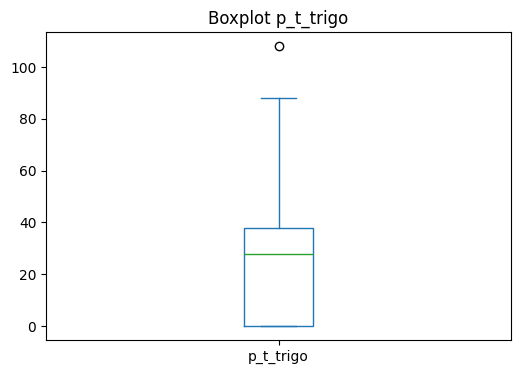


===== p_t_maiz =====
⚠️ 1 valores > 700 g fueron marcados como NaN
count    2907.000000
mean       27.210182
std        12.357050
min         0.000000
25%        23.000000
50%        26.000000
75%        32.000000
max       158.000000
Name: p_t_maiz, dtype: float64


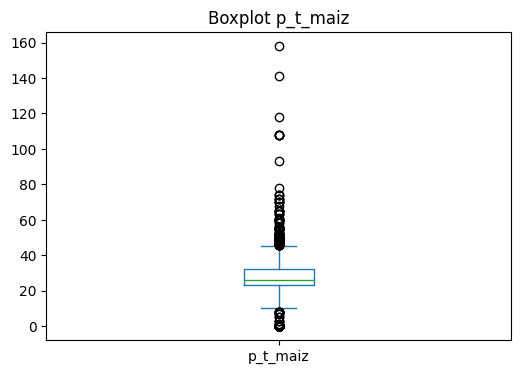

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Selección de columnas y concatenación ---
cols = ['FOLIO_INT','FOLIO_I',"edad", "p_t_trigo", "p_t_maiz"]

frec_pr_w   = dfs['nutricion']['csv']['frec_pr_w'][cols].copy().set_index(['FOLIO_INT','FOLIO_I'])
frec_es_w   = dfs['nutricion']['csv']['frec_es_w'][cols].copy().set_index(['FOLIO_INT','FOLIO_I'])
frec_adul_w = dfs['nutricion']['csv']['frec_adul_w'][cols].copy().set_index(['FOLIO_INT','FOLIO_I'])

frec_all = pd.concat([frec_pr_w, frec_es_w, frec_adul_w], axis=0)

def limpiar_y_filtrar(df, col, threshold=700):
    print(f"\n===== {col} =====")

    # Asegurar string
    df[col] = df[col].astype(str)

    # Valores que representan "faltante"
    valores_atipicos = [",9", "99", "999", "99,9", "999,9"]

    # Reemplazar por NaN
    df[col] = df[col].replace(valores_atipicos, np.nan)

    # Convertir a numérico
    df[col] = pd.to_numeric(df[col], errors='coerce')

    # --- Filtrar valores poco plausibles (> threshold) ---
    n_out = (df[col] > threshold).sum()
    print(f"⚠️ {n_out} valores > {threshold} g fueron marcados como NaN")
    df.loc[df[col] > threshold, col] = np.nan

    # --- Estadísticos básicos ---
    print(df[col].describe())

    # --- Boxplot simple ---
    plt.figure(figsize=(6,4))
    df[col].plot(kind='box')
    plt.title(f"Boxplot {col}")
    plt.show()

    return df

# --- Aplicar a trigo y maíz ---
frec_all = limpiar_y_filtrar(frec_all, 'p_t_trigo')
frec_all = limpiar_y_filtrar(frec_all, 'p_t_maiz')



In [44]:
frec_all.value_counts()

edad  p_t_trigo  p_t_maiz
26    0.0        0.0         3
9     30.0       24.0        2
10    26.0       23.0        2
43    36.0       24.0        2
1     18.0       25.0        2
                            ..
10    14.0       25.0        1
9     61.0       25.0        1
      50.0       26.0        1
      45.0       29.0        1
10    36.0       0.0         1
Name: count, Length: 320, dtype: int64

In [45]:
# Contar frecuencias
vc = frec_all["p_t_maiz"].value_counts()

# Imprimir cada fila
for valor, frecuencia in vc.items():
    print(f"Valor: {valor}, Frecuencia: {frecuencia}")


Valor: 25.0, Frecuencia: 249
Valor: 24.0, Frecuencia: 243
Valor: 26.0, Frecuencia: 228
Valor: 28.0, Frecuencia: 222
Valor: 0.0, Frecuencia: 207
Valor: 30.0, Frecuencia: 200
Valor: 32.0, Frecuencia: 144
Valor: 22.0, Frecuencia: 143
Valor: 23.0, Frecuencia: 104
Valor: 20.0, Frecuencia: 92
Valor: 27.0, Frecuencia: 91
Valor: 35.0, Frecuencia: 77
Valor: 29.0, Frecuencia: 74
Valor: 31.0, Frecuencia: 65
Valor: 34.0, Frecuencia: 60
Valor: 36.0, Frecuencia: 58
Valor: 38.0, Frecuencia: 49
Valor: 21.0, Frecuencia: 48
Valor: 33.0, Frecuencia: 47
Valor: 40.0, Frecuencia: 47
Valor: 18.0, Frecuencia: 41
Valor: 19.0, Frecuencia: 36
Valor: 52.0, Frecuencia: 33
Valor: 42.0, Frecuencia: 30
Valor: 16.0, Frecuencia: 27
Valor: 37.0, Frecuencia: 24
Valor: 48.0, Frecuencia: 22
Valor: 43.0, Frecuencia: 20
Valor: 50.0, Frecuencia: 19
Valor: 39.0, Frecuencia: 18
Valor: 45.0, Frecuencia: 16
Valor: 46.0, Frecuencia: 13
Valor: 14.0, Frecuencia: 12
Valor: 60.0, Frecuencia: 11
Valor: 41.0, Frecuencia: 11
Valor: 44.0,

In [46]:
frec_all

,,edad,p_t_trigo,p_t_maiz
FOLIO_INT,FOLIO_I,,,
2023_01001003_08,2023_01001003,1,NaN,29.0
2023_01001020_04,2023_01001020,1,NaN,NaN
2023_02004023_03,2023_02004023,4,NaN,22.0
2023_03003025_04,2023_03003025,2,NaN,NaN
2023_04003002_06,2023_04003002,2,NaN,NaN
...,...,...,...,...
2023_32024014_01,2023_32024014,82,NaN,0.0
2023_32024022_01,2023_32024022,76,30.0,24.0
2023_32024023_01,2023_32024023,56,30.0,24.0


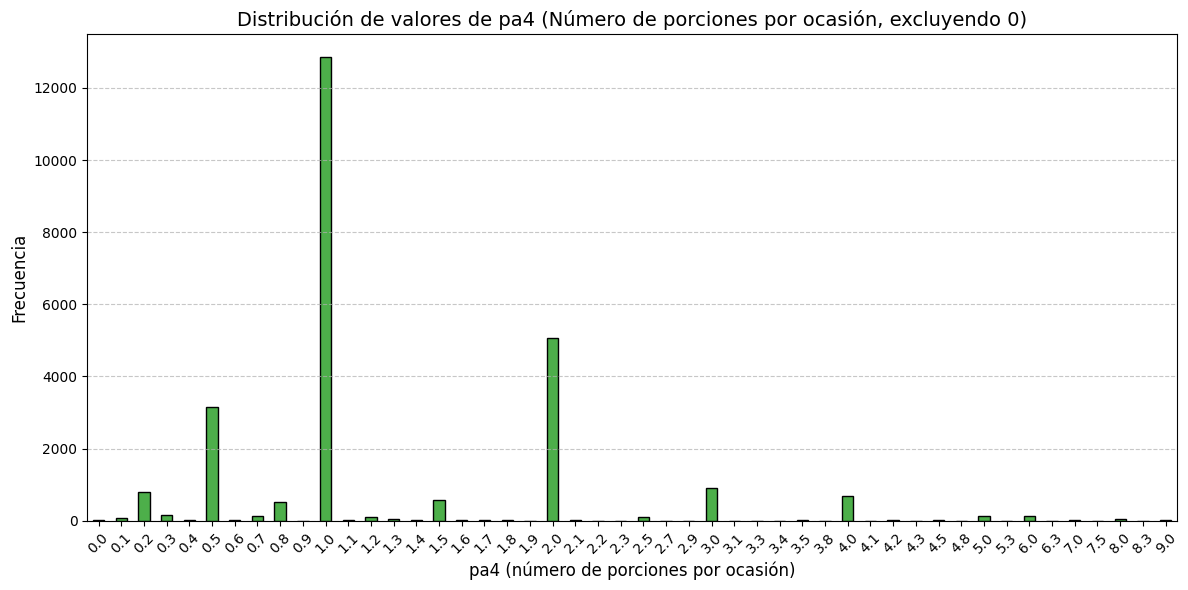

In [47]:
import matplotlib.pyplot as plt
import pandas as pd

# Convertir pa4 a numérico (forzando errores a NaN)
pa4_valid = pd.to_numeric(
    dfs['nutricion']['csv']['frec_es_rec_w']['pa4'], errors='coerce'
)

# Filtrar quitando nulos y ceros
pa4_valid = pa4_valid.dropna()
pa4_valid = pa4_valid[pa4_valid > 0]

# Redondear pa4 a un número con 1 decimal para que no haya tanto ruido en el eje x
pa4_rounded = pa4_valid.round(1)

# Contar frecuencias después de redondear
pa4_counts = pa4_rounded.value_counts().sort_index()

# Graficar histograma mejorado
plt.figure(figsize=(12,6))
pa4_counts.plot(kind='bar', color="#4DAF4A", edgecolor="black")
plt.title("Distribución de valores de pa4 (Número de porciones por ocasión, excluyendo 0)", fontsize=14)
plt.xlabel("pa4 (número de porciones por ocasión)", fontsize=12)
plt.ylabel("Frecuencia", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


In [48]:
dfs['nutricion']['csv']['frec_ad_rec_w']
dfs['nutricion']['csv']['frec_es_rec_w']
dfs['nutricion']['csv']['frec_pr_rec_w']

,FOLIO_INT,FOLIO_I,entidad,desc_ent,municipio,desc_mun,id_alim,alimento,por_est,pa1,esp_alim,pa2,pa3,pa4,maquina1,ponde_f,estrato,est_sel,upm,x_region
0,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,1,Leche materna,1 tetada,0,,,,,MQ650,"76460,9213359616",3,1000,0100100013312,1
1,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,2,Leche Liconsa,1 vaso (240ml),7,,2,ES,0.50,MQ650,"76460,9213359616",3,1000,0100100013312,1
2,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,3,Otra leche opción A,1 vaso (240 ml),0,,,,,MQ650,"76460,9213359616",3,1000,0100100013312,1
3,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,4,Otra leche opción B,1 vaso (240 ml),0,,,,,MQ650,"76460,9213359616",3,1000,0100100013312,1
4,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,5,Otra leche opción C,1 vaso (240 ml),0,,,,,MQ650,"76460,9213359616",3,1000,0100100013312,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87843,2023_32024028_04,2023_32024028,32,32 ZACATECAS,24,024 LORETO,154,Manteca animal (cerdo o pollo),1 cucharada sopera (10g),0,,,,,MQ663,"30778,0113637546",2,32000,3202400010322,1
87844,2023_32024028_04,2023_32024028,32,32 ZACATECAS,24,024 LORETO,155,Sal o condimento con sal agregada a sus alimentos,,0,,,,,MQ663,"30778,0113637546",2,32000,3202400010322,1
87845,2023_32024028_04,2023_32024028,32,32 ZACATECAS,24,024 LORETO,156,Salsas y aderezos agregados a sus alimentos: a...,,0,,,,,MQ663,"30778,0113637546",2,32000,3202400010322,1
87846,2023_32024028_04,2023_32024028,32,32 ZACATECAS,24,024 LORETO,157,Salsas y aderezos agregados a sus alimentos: b...,,0,,,,,MQ663,"30778,0113637546",2,32000,3202400010322,1


In [49]:
import pandas as pd

# 1. Renombrar columnas
df_renamed = dfs['nutricion']['csv']['frec_pr_rec_w'].rename(columns={
    'alimento': 'nombre_alimento',
    'por_est': 'porcion_estandar',
    'pa1': 'dias_semana',
    'pa2': 'veces_dia',
    'pa3': 'tamano_porcion',
    'pa4': 'num_porciones'
})

# 2. Diccionario esp_alim -> descripción
otras_leches_dict = {
    443: "Leche en polvo entera",
    445: "Leche evaporada entera",
    447: "Leche semidescremada",
    452: "Fórmula láctea para bebés de soya",
    1110: "Leche sin lactosa descremada",
    1192: "Leche de soya",
    7000: "Leche entera",
    7001: "Leche descremada",
    7002: "Leche en polvo descremada",
    7003: "Leche evaporada descremada",
    7047: "Atole de maíz con leche entera",
    7048: "Atole de maíz con fórmula láctea para bebés en polvo",
    7049: "Atole de maíz con leche bronca",
    7050: "Atole de maíz con leche light",
    7051: "Atole de maíz con leche en polvo descremada",
    7052: "Atole de maíz con leche entera en polvo",
    7054: "Atole de maíz con leche evaporada entera",
    7055: "Atole de maíz con leche semidescremada",
    7056: "Atole de maíz con leche sin lactosa",
    7057: "Atole de maíz con leche sin lactosa entera",
    7102: "Leche sin lactosa entera",
    7103: "Leche bronca",
    7133: "Atole de maíz con leche evaporada descremada"
}

# 3. Reemplazar o eliminar según el caso
def reemplazar_o_eliminar(row):
    if str(row["nombre_alimento"]).startswith("Otra leche opción"):
        if pd.notna(row["esp_alim"]) and row["esp_alim"] in otras_leches_dict:
            return otras_leches_dict[row["esp_alim"]]
        else:
            return None  # marcar para eliminar
    else:
        return row["nombre_alimento"]

df_renamed["nombre_alimento"] = df_renamed.apply(reemplazar_o_eliminar, axis=1)

# 4. Eliminar filas con None en nombre_alimento
df_renamed = df_renamed.dropna(subset=["nombre_alimento"])

# 5. Limpiar columnas numéricas
for col in ["dias_semana", "veces_dia", "num_porciones"]:
    df_renamed[col] = pd.to_numeric(df_renamed[col], errors="coerce").fillna(0)

df_renamed["dias_semana"] = df_renamed["dias_semana"].astype(int)
df_renamed["veces_dia"] = df_renamed["veces_dia"].astype(int)

# 6. Normalizar columna tamano_porcion
df_renamed["tamano_porcion"] = df_renamed["tamano_porcion"].replace(" ", pd.NA)

# 7. DataFrame final limpio
df_final = df_renamed[['FOLIO_INT','FOLIO_I','nombre_alimento','porcion_estandar',
                       'dias_semana','veces_dia','tamano_porcion','num_porciones']]

# Vista previa
df_final.head()
df_final['porciones_semana'] = df_final['dias_semana']*df_final['veces_dia']*df_final['num_porciones']
df_final['porciones_semana']
valores = ["FOLIO_INT",'FOLIO_I','nombre_alimento','porciones_semana']
df_final[valores]
valores = ['nombre_alimento','porciones_semana']

df_for_trasn = df_final.iloc[:,:].set_index(["FOLIO_INT", "FOLIO_I"])[valores]
df_for_trasn

# Partimos de tu df_final que tiene:
# FOLIO_INT, FOLIO_I, nombre_alimento, porciones_semana

# Crear tabla pivote: individuos como filas, alimentos como columnas
df_corto = df_for_trasn.pivot_table(
    index=["FOLIO_INT", "FOLIO_I"],
    columns="nombre_alimento",
    values="porciones_semana",
    aggfunc="sum",  # sumar si un mismo alimento aparece más de una vez
    fill_value=0    # reemplazar NaN por 0
)

# Quitar jerarquía del índice de columnas
df_corto = df_corto
# Ahora df_corto tiene 1 fila por individuo
print(df_corto.shape)
df_corto.head()



(556, 155)


/tmp/ipython-input-2457667879.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['porciones_semana'] = df_final['dias_semana']*df_final['veces_dia']*df_final['num_porciones']


,nombre_alimento,Agregado a la leche: Azúcar,Agregado a la leche: Chocolate u otro saborizante,Agua sola,Aguacate,Aguas de fruta natural con azúcar,Aguas de fruta natural sin azúcar,"Algún marisco (camarón, ostiones, etc.)","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: a) Sin freír","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: b) Fritos","Antojitos con vegetales como sopes, quesadillas, tlacoyos, gorditas, y enchiladas (NO TACOS): a) Sin freír",...,"Verduras congeladas como chícharo, zanahoria, brócoli, coliflor, ejotes","Verduras envasadas como chícharo, zanahoria, champiñones y ejotes.",Yakult o similares,Yogur de vaso: a) Entero natural,Yogur de vaso: b) Entero con frutas,"Yogur de vaso: c) Bajo en grasa o light natural o con fruta (vitalinea, alpura light, lala light, etc.)",Yogur para beber: a) Entero natural,Yogur para beber: b) Entero con fruta,"Yogur para beber: c) Bajo en grasa o light natural o con fruta (vitalinea, activia 0%, Siluette)",Zanahoria
FOLIO_INT,FOLIO_I,,,,,,,,,,,,,,,,,,,,,
2023_01001003_08,2023_01001003,0.0,0.0,18.62,10.5,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2023_01001020_04,2023_01001020,0.0,0.0,10.50,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25
2023_02004023_03,2023_02004023,0.0,0.0,28.00,0.5,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.00
2023_03003025_04,2023_03003025,0.0,0.0,5.00,0.0,4.0,0.0,0.0,3.0,0.0,0.5,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2023_04003002_06,2023_04003002,0.0,0.0,21.00,0.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,4.00


In [50]:
import pandas as pd

# --- 1. Diccionario esp_alim -> descripción ---
otras_leches_dict = {
    443: "Leche en polvo entera",
    445: "Leche evaporada entera",
    447: "Leche semidescremada",
    452: "Fórmula láctea para bebés de soya",
    1110: "Leche sin lactosa descremada",
    1192: "Leche de soya",
    7000: "Leche entera",
    7001: "Leche descremada",
    7002: "Leche en polvo descremada",
    7003: "Leche evaporada descremada",
    7047: "Atole de maíz con leche entera",
    7048: "Atole de maíz con fórmula láctea para bebés en polvo",
    7049: "Atole de maíz con leche bronca",
    7050: "Atole de maíz con leche light",
    7051: "Atole de maíz con leche en polvo descremada",
    7052: "Atole de maíz con leche entera en polvo",
    7054: "Atole de maíz con leche evaporada entera",
    7055: "Atole de maíz con leche semidescremada",
    7056: "Atole de maíz con leche sin lactosa",
    7057: "Atole de maíz con leche sin lactosa entera",
    7102: "Leche sin lactosa entera",
    7103: "Leche bronca",
    7133: "Atole de maíz con leche evaporada descremada"
}

# --- 2. Función de limpieza/reformateo ---
def procesar_df(df):
    # Renombrar columnas
    df = df.rename(columns={
        'alimento': 'nombre_alimento',
        'por_est': 'porcion_estandar',
        'pa1': 'dias_semana',
        'pa2': 'veces_dia',
        'pa3': 'tamano_porcion',
        'pa4': 'num_porciones'
    })

    # Reemplazo de alimentos "Otra leche ..."
    def reemplazar_o_eliminar(row):
        nombre = str(row["nombre_alimento"]).strip().lower()
        if nombre.startswith("otra leche"):  # atrapa "opción", "a", "b", "c", etc.
            if pd.notna(row["esp_alim"]) and row["esp_alim"] in otras_leches_dict:
                return otras_leches_dict[row["esp_alim"]]
            else:
                return None  # marcar para eliminar
        return row["nombre_alimento"]

    df["nombre_alimento"] = df.apply(reemplazar_o_eliminar, axis=1)

    # Eliminar nulos
    df = df.dropna(subset=["nombre_alimento"])

    # Limpiar columnas numéricas
    for col in ["dias_semana", "veces_dia", "num_porciones"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0).astype(int)

    # Normalizar tamano_porcion
    df["tamano_porcion"] = df["tamano_porcion"].replace(" ", pd.NA)

    # DataFrame final
    df_final = df[['FOLIO_INT','FOLIO_I','nombre_alimento','porcion_estandar',
                   'dias_semana','veces_dia','tamano_porcion','num_porciones']]

    # Nueva columna
    df_final['porciones_semana'] = (
        df_final['dias_semana'] *
        df_final['veces_dia'] *
        df_final['num_porciones']
    )

    # Reorganizar para pivot
    valores = ['nombre_alimento','porciones_semana']
    df_for_trans = df_final.set_index(["FOLIO_INT", "FOLIO_I"])[valores]

    # Tabla pivote
    df_corto = df_for_trans.pivot_table(
        index=["FOLIO_INT", "FOLIO_I"],
        columns="nombre_alimento",
        values="porciones_semana",
        aggfunc="sum",
        fill_value=0
    )

    return df_corto

# --- 3. Aplicar a los tres grupos ---
dfs_limpios = {}
for grupo in ["frec_ad_rec_w", "frec_es_rec_w", "frec_pr_rec_w"]:
    dfs_limpios[grupo] = procesar_df(dfs['nutricion']['csv'][grupo])

# Ejemplo: ver escolares
print(dfs_limpios['frec_es_rec_w'].shape)
dfs_limpios['frec_es_rec_w'].head()


/tmp/ipython-input-4182191332.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['porciones_semana'] = (
/tmp/ipython-input-4182191332.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['porciones_semana'] = (


(816, 154)


/tmp/ipython-input-4182191332.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final['porciones_semana'] = (


,nombre_alimento,Agreagado a la leche: Azúcar,Agreagado a la leche: Chocolate u otro saborizante,Agua sola,Aguacate,Aguas de fruta natural con azúcar,Aguas de fruta natural sin azúcar,"Algún marisco (camarón, ostiones, etc.)","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: a) Sin freír","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: b) Fritos","Antojitos con vegetales como sopes, quesadillas, tlacoyos, gorditas, y enchiladas (NO TACOS): a) Sin freír",...,"Verduras congeladas como chícharo, zanahoria, brócoli, coliflor, ejotes","Verduras envasadas como chícharo, zanahoria, champiñones y ejotes.",Yakult o similares,"Yogur en vaso: Bajo en grasa o light natural o con fruta (vitalínea, alpura light, lala light, etcétera)",Yogur en vaso: Entero con frutas,Yogur en vaso: Entero natural,"Yogur para beber: Bajo en grasa o light natural o con fruta (vitalínea, activia 0%, Siluette, etcétera)",Yogur para beber: Entero con frutas,Yogur para beber: Entero natural,Zanahoria
FOLIO_INT,FOLIO_I,,,,,,,,,,,,,,,,,,,,,
2023_01001003_06,2023_01001003,0,0,14,0,0,0,0,0,2,0,...,0,0,0,0,0,0,0,0,0,0
2023_03003004_03,2023_03003004,0,0,28,6,0,0,1,0,0,0,...,0,0,2,0,0,0,0,0,0,4
2023_03003009_03,2023_03003009,0,0,14,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2023_03003013_04,2023_03003013,0,0,0,42,0,1,0,0,0,0,...,0,0,0,0,0,0,0,2,0,2
2023_04003006_03,2023_04003006,0,7,4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#concatenamos los rangos de edad de los tres datasets prescolar, escolar y adulto:

# Extraer valores únicos como conjuntos
'frec_pr_rec_w' frec_es_rec_w' 'frec_ad_rec_w'

In [51]:
import pandas as pd

# Concatenar todos los DataFrames del diccionario en columnas
df_total = pd.concat(dfs_limpios.values(), axis=0)

print(df_total.shape)
df_total


(3356, 192)


,nombre_alimento,Agregado a la leche: Azúcar,Agregado a la leche: Chocolate u otro saborizante,Agua sola,Aguacate,Aguas de fruta natural con azúcar,Aguas de fruta natural sin azúcar,"Algún marisco (camarón, ostiones, etc.)","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: a) Sin freír","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: b) Fritos","Antojitos con vegetales como sopes, quesadillas, tlacoyos, gorditas, y enchiladas (NO TACOS): a) Sin freír",...,Tamal (todos tipos),"Yogur en vaso: Bajo en grasa o light natural o con fruta (vitalínea, alpura light, lala light, etcétera)",Yogur en vaso: Entero con frutas,Yogur en vaso: Entero natural,"Yogur para beber: Bajo en grasa o light natural o con fruta (vitalínea, activia 0%, Siluette, etcétera)",Yogur para beber: Entero con frutas,Yogur para beber: Entero natural,"Atún y sardina (en tomate, aguo o aceite)",Caldo de frijol,Leche materna
FOLIO_INT,FOLIO_I,,,,,,,,,,,,,,,,,,,,,
2023_01001001_04,2023_01001001,0.0,0.0,16,0,0,0,0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001002_01,2023_01001002,0.0,0.0,28,0,0,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001008_03,2023_01001008,0.0,0.0,0,0,0,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001008_05,2023_01001008,0.0,0.0,21,3,4,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001010_04,2023_01001010,0.0,0.0,56,1,3,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023_31050073_04,2023_31050073,0.0,0.0,56,0,32,0,0,0.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2023_31050089_07,2023_31050089,0.0,0.0,21,0,16,0,0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2023_32024001_05,2023_32024001,0.0,0.0,0,0,0,5,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0



🔹 Valores solo en frec_pr_rec_w:
  1. Atún y sardina (en tomate, aguo o aceite)
  2. Caldo de frijol
  3. Leche materna

🔹 Valores solo en frec_es_rec_w:
  1. Agreagado a la leche: Azúcar
  2. Agreagado a la leche: Chocolate u otro saborizante
  3. Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas,  gorditas: a) Sin freír
  4. Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas,  gorditas: b) Fritos
  5. Atole de maíz  b) Atole con leche (aparte de la reportada en el apartado de “Productos lácteos”)
  6. Cereal de caja: a) Chocolate (Chocozucaritas, chocokrispis)
  7. Cereal de caja: b) Light/cuidado de la figura (Special K)
  8. Cereal de caja: c) Hojuela endulzada (Zucaritas)
  9. Cereal de caja: d) Básico (Corn Flakes, arroz inflado sin sabor)
  10. Cereal de caja: e) Variedades (Apple jacks, honey smacks, corn pops)
  11. Cereal de caja: f) Sabor a frutas (Froot loops)
  12. Cereal de caja: g) Fibra 

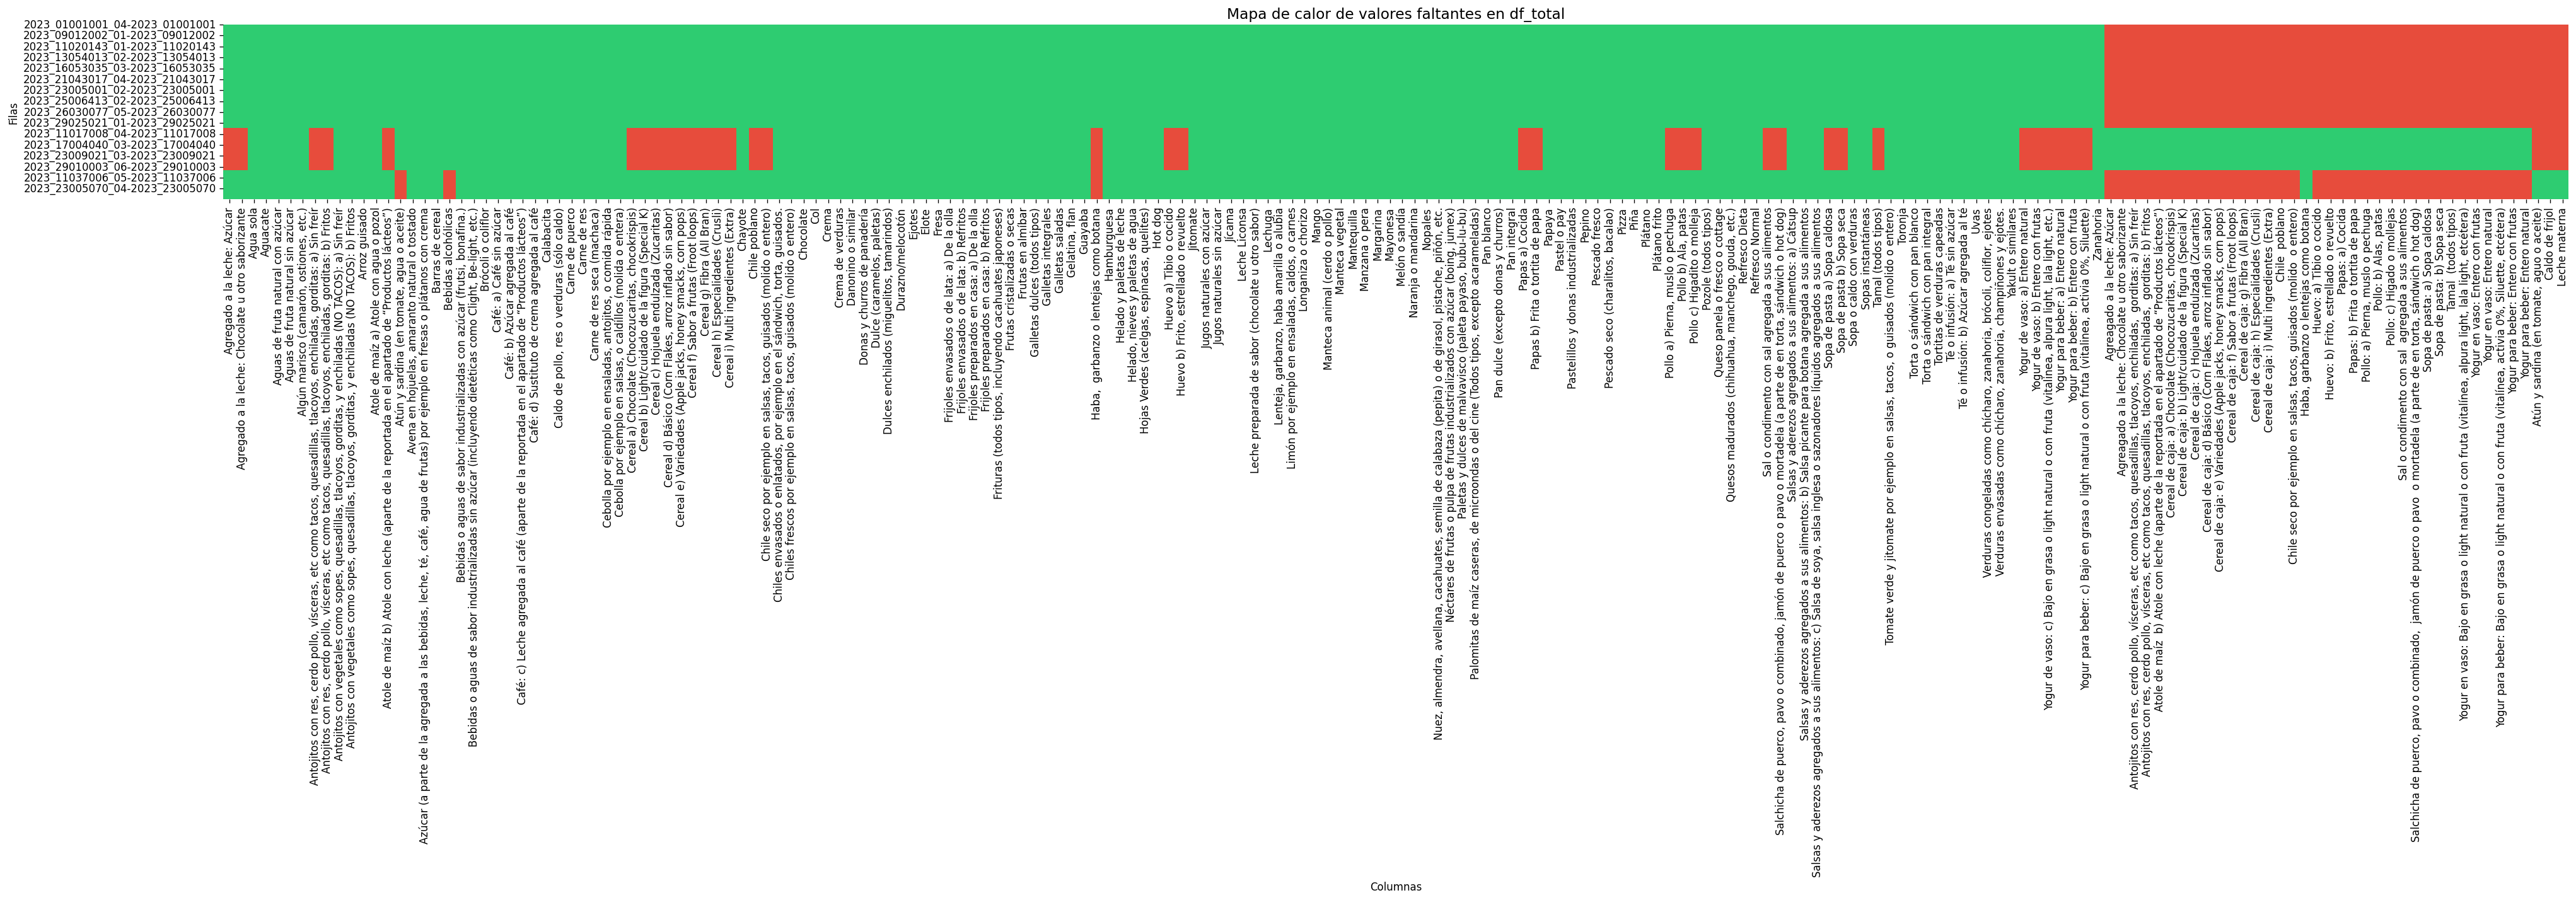

(3356, 192)


In [52]:
# Extraer valores únicos como conjuntos
pr = set(dfs['nutricion']['csv']['frec_pr_rec_w']['alimento'].dropna().unique())
es = set(dfs['nutricion']['csv']['frec_es_rec_w']['alimento'].dropna().unique())
ad = set(dfs['nutricion']['csv']['frec_ad_rec_w']['alimento'].dropna().unique())

# Valores únicos en cada dataset
solo_pr = sorted(pr - es - ad)
solo_es = sorted(es - pr - ad)
solo_ad = sorted(ad - pr - es)

# --- NUEVO: valores en exactamente dos grupos ---
pr_es = sorted((pr & es) - ad)   # en preescolares y escolares, pero no en adultos
pr_ad = sorted((pr & ad) - es)   # en preescolares y adultos, pero no en escolares
es_ad = sorted((es & ad) - pr)   # en escolares y adultos, pero no en preescolares

def enumerar(nombre, valores):
    print(f"\n🔹 Valores {nombre}:")
    if valores:
        for i, v in enumerate(valores, 1):
            print(f"  {i}. {v}")
    else:
        print("  (ninguno)")

# Mostrar resultados
enumerar("solo en frec_pr_rec_w", solo_pr)
enumerar("solo en frec_es_rec_w", solo_es)
enumerar("solo en frec_ad_rec_w", solo_ad)

enumerar("en pr y es (no en ad)", pr_es)
enumerar("en pr y ad (no en es)", pr_ad)
enumerar("en es y ad (no en pr)", es_ad)

# --- Opcional: ver también los que están en los tres ---
en_tres = sorted(pr & es & ad)
enumerar("en los tres grupos", en_tres)


# --- Visualización de nulos en df_total ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40,3), dpi=120)
sns.heatmap(
    df_total.isna(),
    cbar=False,
    cmap=["#2ecc71", "#e74c3c"]  # verde = datos, rojo = NaN
)
plt.title("Mapa de calor de valores faltantes en df_total", fontsize=14)
plt.xlabel("Columnas")
plt.ylabel("Filas")
plt.show()

print(df_total.shape)

#si quitamos los nan's sería

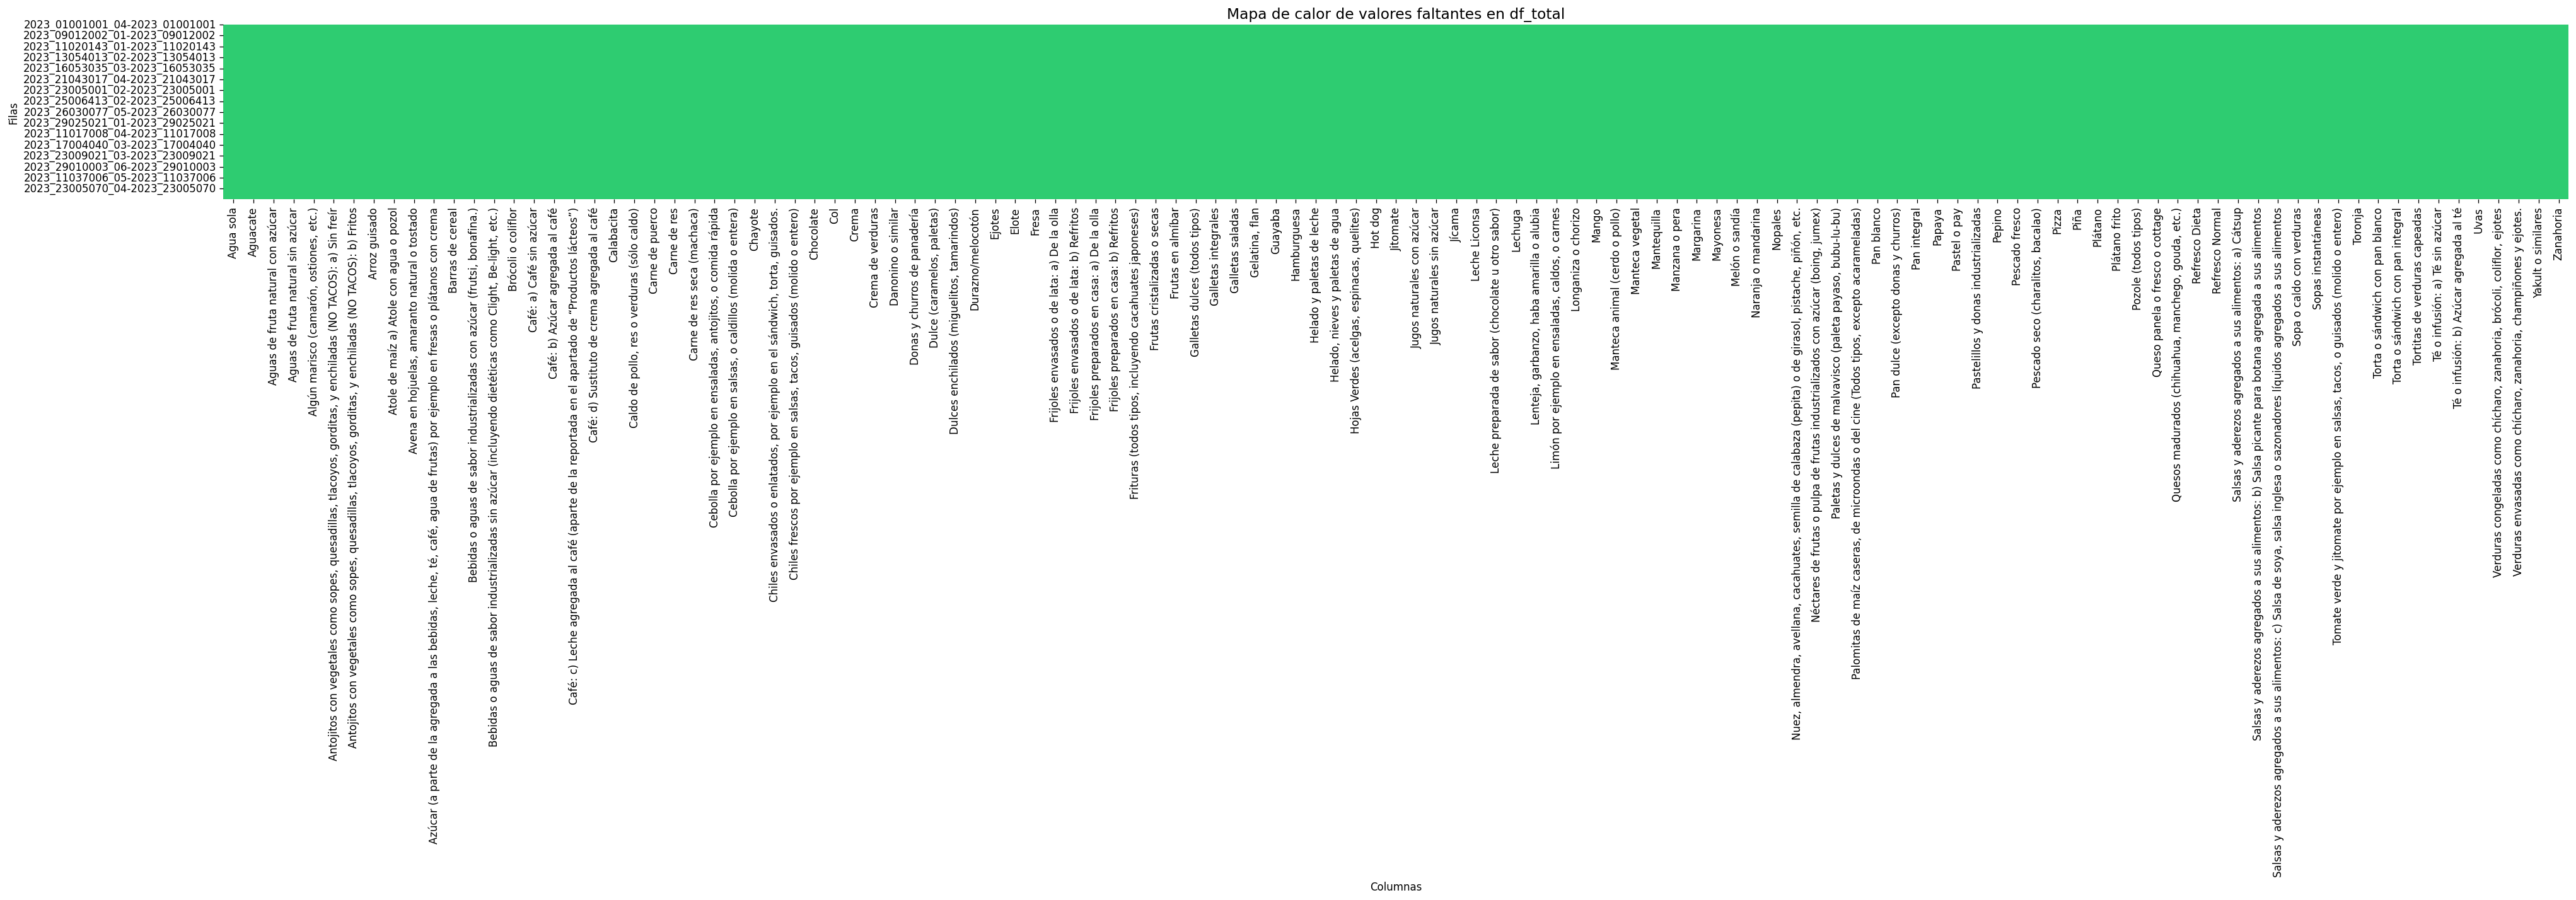

(3356, 117)


In [53]:
df_total_clean = df_total.dropna(axis=1)


# --- Visualización de nulos en df_total ---
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(40,3), dpi=120)
sns.heatmap(
    df_total_clean.isna(),
    cbar=False,
    cmap=["#2ecc71", "#e74c3c"]  # verde = datos, rojo = NaN
)
plt.title("Mapa de calor de valores faltantes en df_total", fontsize=14)
plt.xlabel("Columnas")
plt.ylabel("Filas")
plt.show()

print(df_total_clean.shape)

In [54]:
print("sin quitar nans",df_total.shape)

print("quitando nans",df_total_clean.shape)

print("cuantos se perdieron", df_total.shape[1]-df_total_clean.shape[1])

sin quitar nans (3356, 192)
quitando nans (3356, 117)
cuantos se perdieron 75


#frec_pr_tor_w: **Frecuencia de consumo de alimentos - Complemento (Tortilla)**

In [55]:
variables_t = ['FOLIO_INT','FOLIO_I','id_tortillas','tortillas','pa1_t','pa4_t']
tortillas = dfs['nutricion']['csv']['frec_pr_tor_w'][variables_t].set_index(['FOLIO_INT','FOLIO_I'])
# Diccionario de variables de tortillas
tortillas_dict = {
    "FOLIO_INT": "Identificador único del individuo en la encuesta (con sufijo del módulo)",
    "FOLIO_I": "Identificador único del individuo en la encuesta (ID general)",
    "id_tortillas": "Código del alimento: tortillas",
    "tortillas": "Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",
    "pa1_t": "Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)",
    "pa4_t": "Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)"
}
tortillas = tortillas.rename(columns=tortillas_dict, inplace=False)  # inplace=True si quieres sobrescribir
tortillas

variables= ['Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)','Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)','Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)']
tor= tortillas[variables]
tor
# Aseguramos que pa1_t y pa4_t estén en numérico y sin nulos
tor["pa1_t"] = pd.to_numeric(tor["Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)"], errors="coerce").fillna(0)
tor["pa4_t"] = pd.to_numeric(tor['Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)'], errors="coerce").fillna(0)

# Calculamos el total de tortillas por semana
tor["num_tortillas_sem"] = tor["pa1_t"] * tor["pa4_t"]
variables = ['Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)','num_tortillas_sem']
tor[variables]


# Hacer pivot: cada tipo de tortilla será columna
tor_wide = tor.reset_index().pivot_table(
    index=["FOLIO_INT", "FOLIO_I"],
    columns="Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",
    values="num_tortillas_sem",
    aggfunc="sum",  # si hubiera duplicados, los suma
    fill_value=0    # reemplazar NaN por 0
)

# Quitar el nombre de columnas multiíndice
tor_wide.columns.name = None

# Resetear índice si lo quieres en formato plano
tor_wide = tor_wide.reset_index()

tor_wide.head()

tor_wide = tor_wide.set_index(['FOLIO_INT','FOLIO_I'])
tor_wide


,,Tortillas de harina de trigo,Tortillas de maiz de harina MASECA o MINSA (hecha a mano),Tortillas de maiz de nixtamal (hecha a mano),Tortillas de maiz de tortillería
FOLIO_INT,FOLIO_I,,,,
2023_01001003_08,2023_01001003,0.0,0.0,0.0,14.0
2023_01001020_04,2023_01001020,0.0,0.0,0.0,0.0
2023_02004023_03,2023_02004023,0.0,0.0,0.0,14.0
2023_03003025_04,2023_03003025,1.0,0.0,0.0,7.0
2023_04003002_06,2023_04003002,0.0,0.0,0.0,9.0
...,...,...,...,...,...
2023_31050073_04,2023_31050073,0.0,0.0,0.0,0.0
2023_31050089_07,2023_31050089,0.0,2.0,0.0,2.0
2023_32024001_05,2023_32024001,0.0,0.0,0.0,14.0


# PREESCOLAR TORTILLAS

In [56]:
import pandas as pd

def preparar_consumo(df, variables, rename_dict, col_tipo, col_dias, col_porciones, id_cols=["FOLIO_INT","FOLIO_I"]):
    """
    Prepara el DataFrame de consumo semanal por tipo de alimento.



    # El producto final (tor_wide) es un DataFrame en formato ancho donde cada fila
    # corresponde a un individuo (FOLIO_INT, FOLIO_I), y cada columna representa
    # un tipo de tortilla consumida. El valor en cada celda es el número total
    # de tortillas consumidas por semana para ese tipo, calculado como
    # (días de consumo en la semana × número de tortillas por día).

    """

    print("👉 DataFrame original")
    display(df.head())

    # Seleccionar columnas relevantes
    df_sel = df[variables].rename(columns=rename_dict, inplace=False)
    print("\n Después de seleccionar y renombrar columnas")
    display(df_sel.head())

    # Asegurar tipos numéricos
    df_sel[col_dias] = pd.to_numeric(df_sel[col_dias], errors="coerce").fillna(0)
    df_sel[col_porciones] = pd.to_numeric(df_sel[col_porciones], errors="coerce").fillna(0)
    print("\nDespués de convertir días y porciones a numérico")
    display(df_sel[[col_dias, col_porciones]].head())

    # Calcular consumo semanal
    df_sel["num_sem"] = df_sel[col_dias] * df_sel[col_porciones]
    print("\nDespués de calcular consumo semanal")
    display(df_sel[[col_tipo, col_dias, col_porciones, "num_sem"]].head())

    # Pivot table
    df_wide = df_sel.pivot_table(
        index=id_cols,
        columns=col_tipo,
        values="num_sem",
        aggfunc="sum",
        fill_value=0
    )

    # Limpiar nombres
    df_wide.columns.name = None
    df_wide = df_wide#.reset_index()

    print("\n Resultado final (formato ancho)")
    display(df_wide.head())

    return df_wide


# -------- EJEMPLO CON TORTILLAS -------- #
variables_t = ['FOLIO_INT','FOLIO_I','id_tortillas','tortillas','pa1_t','pa4_t']

tortillas_dict = {
    "id_tortillas": "Código del alimento: tortillas",
    "tortillas": "Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",
    "pa1_t": "Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)",
    "pa4_t": "Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)"
}

tor_wide = preparar_consumo(
    df=dfs['nutricion']['csv']['frec_pr_tor_w'],  # ahora paso el df sin set_index
    variables=variables_t,
    rename_dict=tortillas_dict,
    col_tipo="Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",
    col_dias="Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)",
    col_porciones="Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)",
    id_cols=["FOLIO_INT","FOLIO_I"]
)
tor_wide_pr = tor_wide

👉 DataFrame original


,FOLIO_INT,FOLIO_I,entidad,desc_ent,municipio,desc_mun,id_tortillas,tortillas,pa1_t,pa4_t,maquina2,ponde_f,estrato,est_sel,upm,x_region
0,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,159,Tortillas de maiz de nixtamal (hecha a mano),9,,MQ650,"76460,9213359616",3,1000,0100100013312,1
1,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,160,Tortillas de maiz de harina MASECA o MINSA (he...,9,,MQ650,"76460,9213359616",3,1000,0100100013312,1
2,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,161,Tortillas de maiz de tortillería,7,2,MQ650,"76460,9213359616",3,1000,0100100013312,1
3,2023_01001003_08,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,162,Tortillas de harina de trigo,9,,MQ650,"76460,9213359616",3,1000,0100100013312,1
4,2023_01001020_04,2023_01001020,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,159,Tortillas de maiz de nixtamal (hecha a mano),9,,MQ648,"88003,6944684075",3,1000,0100100013312,1



 Después de seleccionar y renombrar columnas


,FOLIO_INT,FOLIO_I,Código del alimento: tortillas,"Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)
0,2023_01001003_08,2023_01001003,159,Tortillas de maiz de nixtamal (hecha a mano),9,
1,2023_01001003_08,2023_01001003,160,Tortillas de maiz de harina MASECA o MINSA (he...,9,
2,2023_01001003_08,2023_01001003,161,Tortillas de maiz de tortillería,7,2
3,2023_01001003_08,2023_01001003,162,Tortillas de harina de trigo,9,
4,2023_01001020_04,2023_01001020,159,Tortillas de maiz de nixtamal (hecha a mano),9,



Después de convertir días y porciones a numérico


,Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)
0,9,0.0
1,9,0.0
2,7,2.0
3,9,0.0
4,9,0.0



Después de calcular consumo semanal


,"Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos),num_sem
0,Tortillas de maiz de nixtamal (hecha a mano),9,0.0,0.0
1,Tortillas de maiz de harina MASECA o MINSA (he...,9,0.0,0.0
2,Tortillas de maiz de tortillería,7,2.0,14.0
3,Tortillas de harina de trigo,9,0.0,0.0
4,Tortillas de maiz de nixtamal (hecha a mano),9,0.0,0.0



 Resultado final (formato ancho)


,,Tortillas de harina de trigo,Tortillas de maiz de harina MASECA o MINSA (hecha a mano),Tortillas de maiz de nixtamal (hecha a mano),Tortillas de maiz de tortillería
FOLIO_INT,FOLIO_I,,,,
2023_01001003_08,2023_01001003,0.0,0.0,0.0,14.0
2023_01001020_04,2023_01001020,0.0,0.0,0.0,0.0
2023_02004023_03,2023_02004023,0.0,0.0,0.0,14.0
2023_03003025_04,2023_03003025,1.0,0.0,0.0,7.0
2023_04003002_06,2023_04003002,0.0,0.0,0.0,9.0


#ESCOLAR TORTILLAS

In [57]:
import pandas as pd

def preparar_consumo(df, variables, rename_dict, col_tipo, col_dias, col_porciones, id_cols=["FOLIO_INT","FOLIO_I"]):
    """
    Prepara el DataFrame de consumo semanal por tipo de alimento.



    # El producto final (tor_wide) es un DataFrame en formato ancho donde cada fila
    # corresponde a un individuo (FOLIO_INT, FOLIO_I), y cada columna representa
    # un tipo de tortilla consumida. El valor en cada celda es el número total
    # de tortillas consumidas por semana para ese tipo, calculado como
    # (días de consumo en la semana × número de tortillas por día).

    """

    print("👉 DataFrame original")
    display(df.head())

    # Seleccionar columnas relevantes
    df_sel = df[variables].rename(columns=rename_dict, inplace=False)
    print("\n Después de seleccionar y renombrar columnas")
    display(df_sel.head())

    # Asegurar tipos numéricos
    df_sel[col_dias] = pd.to_numeric(df_sel[col_dias], errors="coerce").fillna(0)
    df_sel[col_porciones] = pd.to_numeric(df_sel[col_porciones], errors="coerce").fillna(0)
    print("\nDespués de convertir días y porciones a numérico")
    display(df_sel[[col_dias, col_porciones]].head())

    # Calcular consumo semanal
    df_sel["num_sem"] = df_sel[col_dias] * df_sel[col_porciones]
    print("\nDespués de calcular consumo semanal")
    display(df_sel[[col_tipo, col_dias, col_porciones, "num_sem"]].head())

    # Pivot table
    df_wide = df_sel.pivot_table(
        index=id_cols,
        columns=col_tipo,
        values="num_sem",
        aggfunc="sum",
        fill_value=0
    )

    # Limpiar nombres
    df_wide.columns.name = None
    df_wide = df_wide#.reset_index()

    print("\n Resultado final (formato ancho)")
    display(df_wide.head())

    return df_wide


# -------- EJEMPLO CON TORTILLAS -------- #
variables_t = ['FOLIO_INT','FOLIO_I','id_tortillas','tortillas','pa1_t','pa4_t']

tortillas_dict = {
    "id_tortillas": "Código del alimento: tortillas",
    "tortillas": "Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",
    "pa1_t": "Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)",
    "pa4_t": "Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)"
}

tor_wide = preparar_consumo(
    df=dfs['nutricion']['csv']['frec_es_tor_w'],  # ahora paso el df sin set_index
    variables=variables_t,
    rename_dict=tortillas_dict,
    col_tipo="Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",
    col_dias="Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)",
    col_porciones="Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)",
    id_cols=["FOLIO_INT","FOLIO_I"]
)
tor_wide_es = tor_wide

👉 DataFrame original


,FOLIO_INT,FOLIO_I,entidad,desc_ent,municipio,desc_mun,id_tortillas,tortillas,pa1_t,pa4_t,maquina2,ponde_f,estrato,est_sel,upm,x_region
0,2023_01001003_06,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,158,Tortillas de maiz de nixtamal (hecha a mano),9,,MQ650,"78918,4780768386",3,1000,0100100013312,1
1,2023_01001003_06,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,159,Tortillas de maiz de harina MASECA o MINSA (he...,9,,MQ650,"78918,4780768386",3,1000,0100100013312,1
2,2023_01001003_06,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,160,Tortillas de maiz de tortillería,7,3,MQ650,"78918,4780768386",3,1000,0100100013312,1
3,2023_01001003_06,2023_01001003,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,161,Tortillas de harina de trigo,9,,MQ650,"78918,4780768386",3,1000,0100100013312,1
4,2023_03003004_03,2023_03003004,3,03 BAJA CALIFORNIA SUR,3,003 LA PAZ,158,Tortillas de maiz de nixtamal (hecha a mano),9,,MQ614,"33811,6309173516",3,3000,0300300011998,1



 Después de seleccionar y renombrar columnas


,FOLIO_INT,FOLIO_I,Código del alimento: tortillas,"Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)
0,2023_01001003_06,2023_01001003,158,Tortillas de maiz de nixtamal (hecha a mano),9,
1,2023_01001003_06,2023_01001003,159,Tortillas de maiz de harina MASECA o MINSA (he...,9,
2,2023_01001003_06,2023_01001003,160,Tortillas de maiz de tortillería,7,3
3,2023_01001003_06,2023_01001003,161,Tortillas de harina de trigo,9,
4,2023_03003004_03,2023_03003004,158,Tortillas de maiz de nixtamal (hecha a mano),9,



Después de convertir días y porciones a numérico


,Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)
0,9,0.0
1,9,0.0
2,7,3.0
3,9,0.0
4,9,0.0



Después de calcular consumo semanal


,"Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos),num_sem
0,Tortillas de maiz de nixtamal (hecha a mano),9,0.0,0.0
1,Tortillas de maiz de harina MASECA o MINSA (he...,9,0.0,0.0
2,Tortillas de maiz de tortillería,7,3.0,21.0
3,Tortillas de harina de trigo,9,0.0,0.0
4,Tortillas de maiz de nixtamal (hecha a mano),9,0.0,0.0



 Resultado final (formato ancho)


,,Tortillas de harina de trigo,Tortillas de maiz de harina MASECA o MINSA (hecha a mano),Tortillas de maiz de nixtamal (hecha a mano),Tortillas de maiz de tortillería
FOLIO_INT,FOLIO_I,,,,
2023_01001003_06,2023_01001003,0.0,0.0,0.0,21.0
2023_03003004_03,2023_03003004,0.0,0.0,0.0,6.0
2023_03003009_03,2023_03003009,0.0,0.0,0.0,2.0
2023_03003013_04,2023_03003013,0.0,0.0,0.0,2.0
2023_04003006_03,2023_04003006,0.0,0.0,0.0,0.0


In [58]:
import pandas as pd

def preparar_consumo(df, variables, rename_dict, col_tipo, col_dias, col_porciones, id_cols=["FOLIO_INT","FOLIO_I"]):
    """
    Prepara el DataFrame de consumo semanal por tipo de alimento.



    # El producto final (tor_wide) es un DataFrame en formato ancho donde cada fila
    # corresponde a un individuo (FOLIO_INT, FOLIO_I), y cada columna representa
    # un tipo de tortilla consumida. El valor en cada celda es el número total
    # de tortillas consumidas por semana para ese tipo, calculado como
    # (días de consumo en la semana × número de tortillas por día).

    """

    print("👉 DataFrame original")
    display(df.head())

    # Seleccionar columnas relevantes
    df_sel = df[variables].rename(columns=rename_dict, inplace=False)
    print("\n Después de seleccionar y renombrar columnas")
    display(df_sel.head())

    # Asegurar tipos numéricos
    df_sel[col_dias] = pd.to_numeric(df_sel[col_dias], errors="coerce").fillna(0)
    df_sel[col_porciones] = pd.to_numeric(df_sel[col_porciones], errors="coerce").fillna(0)
    print("\nDespués de convertir días y porciones a numérico")
    display(df_sel[[col_dias, col_porciones]].head())

    # Calcular consumo semanal
    df_sel["num_sem"] = df_sel[col_dias] * df_sel[col_porciones]
    print("\nDespués de calcular consumo semanal")
    display(df_sel[[col_tipo, col_dias, col_porciones, "num_sem"]].head())

    # Pivot table
    df_wide = df_sel.pivot_table(
        index=id_cols,
        columns=col_tipo,
        values="num_sem",
        aggfunc="sum",
        fill_value=0
    )

    # Limpiar nombres
    df_wide.columns.name = None
    df_wide = df_wide#.reset_index()

    print("\n Resultado final (formato ancho)")
    display(df_wide.head())

    return df_wide


# -------- EJEMPLO CON TORTILLAS -------- #
variables_t = ['FOLIO_INT','FOLIO_I','id_tortillas','tortillas','pa1_t','pa4_t']

tortillas_dict = {
    "id_tortillas": "Código del alimento: tortillas",
    "tortillas": "Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",
    "pa1_t": "Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)",
    "pa4_t": "Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)"
}

tor_wide = preparar_consumo(
    df=dfs['nutricion']['csv']['frec_ad_tor_w'],  # ahora paso el df sin set_index
    variables=variables_t,
    rename_dict=tortillas_dict,
    col_tipo="Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",
    col_dias="Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos)",
    col_porciones="Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)",
    id_cols=["FOLIO_INT","FOLIO_I"]
)
tor_wide_ad = tor_wide
tor_wide_ad

👉 DataFrame original


,FOLIO_INT,FOLIO_I,entidad,desc_ent,municipio,desc_mun,id_tortillas,tortillas,pa1_t,pa4_t,maquina2,ponde_f,estrato,est_sel,upm,x_region
0,2023_01001001_04,2023_01001001,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,158,Tortillas de maiz de nixtamal (hecha a mano),9,,MQ650,"125042,437112786",3,1000,0100100013312,1
1,2023_01001001_04,2023_01001001,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,159,Tortillas de maiz de harina MASECA o MINSA (he...,9,,MQ650,"125042,437112786",3,1000,0100100013312,1
2,2023_01001001_04,2023_01001001,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,160,Tortillas de maiz de tortillería,7,8,MQ650,"125042,437112786",3,1000,0100100013312,1
3,2023_01001001_04,2023_01001001,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,161,Tortillas de harina de trigo,4,2,MQ650,"125042,437112786",3,1000,0100100013312,1
4,2023_01001002_01,2023_01001002,1,01 AGUASCALIENTES,1,001 AGUASCALIENTES,158,Tortillas de maiz de nixtamal (hecha a mano),9,,MQ650,"132258,432122237",3,1000,0100100013312,1



 Después de seleccionar y renombrar columnas


,FOLIO_INT,FOLIO_I,Código del alimento: tortillas,"Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)
0,2023_01001001_04,2023_01001001,158,Tortillas de maiz de nixtamal (hecha a mano),9,
1,2023_01001001_04,2023_01001001,159,Tortillas de maiz de harina MASECA o MINSA (he...,9,
2,2023_01001001_04,2023_01001001,160,Tortillas de maiz de tortillería,7,8
3,2023_01001001_04,2023_01001001,161,Tortillas de harina de trigo,4,2
4,2023_01001002_01,2023_01001002,158,Tortillas de maiz de nixtamal (hecha a mano),9,



Después de convertir días y porciones a numérico


,Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos)
0,9,0.0
1,9,0.0
2,7,8.0
3,4,2.0
4,9,0.0



Después de calcular consumo semanal


,"Tipo de tortilla consumida (ej. nixtamal, harina, tortillería, etc.)",Número de días a la semana en que consumió tortillas (excluyendo enchiladas/antojitos),Número de tortillas consumidas cada día que las comió (excluyendo enchiladas/antojitos),num_sem
0,Tortillas de maiz de nixtamal (hecha a mano),9,0.0,0.0
1,Tortillas de maiz de harina MASECA o MINSA (he...,9,0.0,0.0
2,Tortillas de maiz de tortillería,7,8.0,56.0
3,Tortillas de harina de trigo,4,2.0,8.0
4,Tortillas de maiz de nixtamal (hecha a mano),9,0.0,0.0



 Resultado final (formato ancho)


,,Tortillas de harina de trigo,Tortillas de maiz de harina MASECA o MINSA (hecha a mano),Tortillas de maiz de nixtamal (hecha a mano),Tortillas de maiz de tortillería
FOLIO_INT,FOLIO_I,,,,
2023_01001001_04,2023_01001001,8.0,0.0,0.0,56.0
2023_01001002_01,2023_01001002,0.0,0.0,0.0,49.0
2023_01001008_03,2023_01001008,0.0,0.0,0.0,56.0
2023_01001008_05,2023_01001008,0.0,0.0,4.0,105.0
2023_01001010_04,2023_01001010,0.0,0.0,0.0,20.0


,,Tortillas de harina de trigo,Tortillas de maiz de harina MASECA o MINSA (hecha a mano),Tortillas de maiz de nixtamal (hecha a mano),Tortillas de maiz de tortillería
FOLIO_INT,FOLIO_I,,,,
2023_01001001_04,2023_01001001,8.0,0.0,0.0,56.0
2023_01001002_01,2023_01001002,0.0,0.0,0.0,49.0
2023_01001008_03,2023_01001008,0.0,0.0,0.0,56.0
2023_01001008_05,2023_01001008,0.0,0.0,4.0,105.0
2023_01001010_04,2023_01001010,0.0,0.0,0.0,20.0
...,...,...,...,...,...
2023_32024014_01,2023_32024014,0.0,0.0,0.0,21.0
2023_32024022_01,2023_32024022,1.0,0.0,0.0,35.0
2023_32024023_01,2023_32024023,3.0,0.0,0.0,21.0


In [59]:
print("complemento tortilla",tor_wide_pr.shape)
print("complemento tortilla",tor_wide_es.shape)
print("complemento tortilla",tor_wide_ad.shape)

complemento tortilla (556, 4)
complemento tortilla (816, 4)
complemento tortilla (1984, 4)


In [60]:
tortilla_4 = pd.concat([tor_wide_pr, tor_wide_es, tor_wide_ad], axis=0)
tortilla_4

,,Tortillas de harina de trigo,Tortillas de maiz de harina MASECA o MINSA (hecha a mano),Tortillas de maiz de nixtamal (hecha a mano),Tortillas de maiz de tortillería
FOLIO_INT,FOLIO_I,,,,
2023_01001003_08,2023_01001003,0.0,0.0,0.0,14.0
2023_01001020_04,2023_01001020,0.0,0.0,0.0,0.0
2023_02004023_03,2023_02004023,0.0,0.0,0.0,14.0
2023_03003025_04,2023_03003025,1.0,0.0,0.0,7.0
2023_04003002_06,2023_04003002,0.0,0.0,0.0,9.0
...,...,...,...,...,...
2023_32024014_01,2023_32024014,0.0,0.0,0.0,21.0
2023_32024022_01,2023_32024022,1.0,0.0,0.0,35.0
2023_32024023_01,2023_32024023,3.0,0.0,0.0,21.0


<Axes: ylabel='FOLIO_INT-FOLIO_I'>

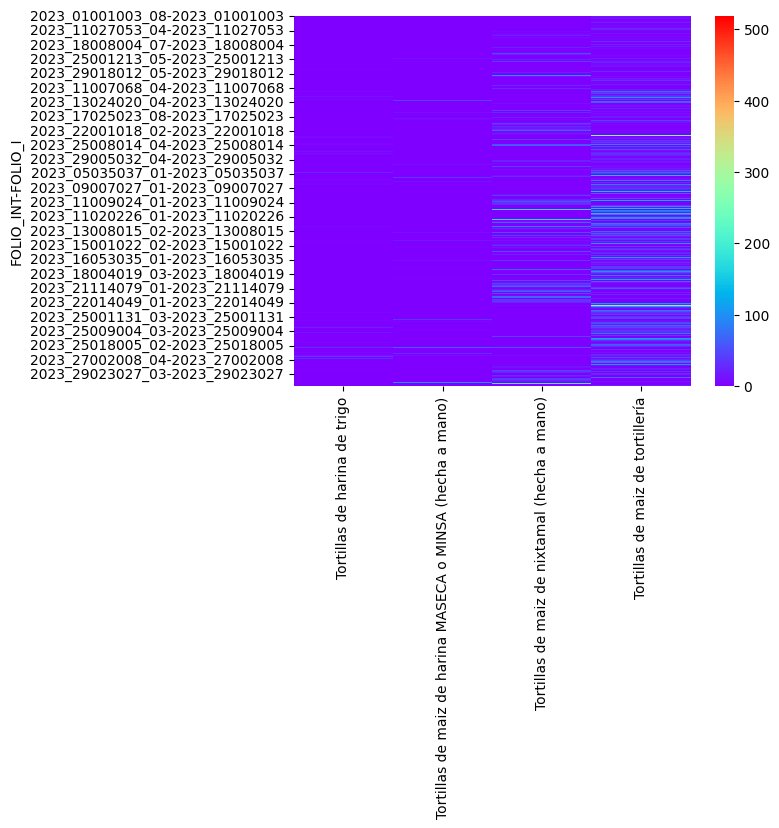

In [61]:
sns.heatmap(tortilla_4, cmap='rainbow')

In [63]:
tortilla_4

,,Tortillas de harina de trigo,Tortillas de maiz de harina MASECA o MINSA (hecha a mano),Tortillas de maiz de nixtamal (hecha a mano),Tortillas de maiz de tortillería
FOLIO_INT,FOLIO_I,,,,
2023_01001003_08,2023_01001003,0.0,0.0,0.0,14.0
2023_01001020_04,2023_01001020,0.0,0.0,0.0,0.0
2023_02004023_03,2023_02004023,0.0,0.0,0.0,14.0
2023_03003025_04,2023_03003025,1.0,0.0,0.0,7.0
2023_04003002_06,2023_04003002,0.0,0.0,0.0,9.0
...,...,...,...,...,...
2023_32024014_01,2023_32024014,0.0,0.0,0.0,21.0
2023_32024022_01,2023_32024022,1.0,0.0,0.0,35.0
2023_32024023_01,2023_32024023,3.0,0.0,0.0,21.0


#matrices importantes

,nombre_alimento,Agregado a la leche: Azúcar,Agregado a la leche: Chocolate u otro saborizante,Agua sola,Aguacate,Aguas de fruta natural con azúcar,Aguas de fruta natural sin azúcar,"Algún marisco (camarón, ostiones, etc.)","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: a) Sin freír","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: b) Fritos","Antojitos con vegetales como sopes, quesadillas, tlacoyos, gorditas, y enchiladas (NO TACOS): a) Sin freír",...,Tamal (todos tipos),"Yogur en vaso: Bajo en grasa o light natural o con fruta (vitalínea, alpura light, lala light, etcétera)",Yogur en vaso: Entero con frutas,Yogur en vaso: Entero natural,"Yogur para beber: Bajo en grasa o light natural o con fruta (vitalínea, activia 0%, Siluette, etcétera)",Yogur para beber: Entero con frutas,Yogur para beber: Entero natural,"Atún y sardina (en tomate, aguo o aceite)",Caldo de frijol,Leche materna
FOLIO_INT,FOLIO_I,,,,,,,,,,,,,,,,,,,,,
2023_01001001_04,2023_01001001,0.0,0.0,16,0,0,0,0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001002_01,2023_01001002,0.0,0.0,28,0,0,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001008_03,2023_01001008,0.0,0.0,0,0,0,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001008_05,2023_01001008,0.0,0.0,21,3,4,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001010_04,2023_01001010,0.0,0.0,56,1,3,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023_31050073_04,2023_31050073,0.0,0.0,56,0,32,0,0,0.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2023_31050089_07,2023_31050089,0.0,0.0,21,0,16,0,0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2023_32024001_05,2023_32024001,0.0,0.0,0,0,0,5,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0


#información de tortillas peso promedio de tortilla de tirgo y arina

In [65]:
frec_all

,,edad,p_t_trigo,p_t_maiz
FOLIO_INT,FOLIO_I,,,
2023_01001003_08,2023_01001003,1,NaN,29.0
2023_01001020_04,2023_01001020,1,NaN,NaN
2023_02004023_03,2023_02004023,4,NaN,22.0
2023_03003025_04,2023_03003025,2,NaN,NaN
2023_04003002_06,2023_04003002,2,NaN,NaN
...,...,...,...,...
2023_32024014_01,2023_32024014,82,NaN,0.0
2023_32024022_01,2023_32024022,76,30.0,24.0
2023_32024023_01,2023_32024023,56,30.0,24.0


#numero de toritallas semanales por tipo de tortilla

In [66]:
tortilla_4

,,Tortillas de harina de trigo,Tortillas de maiz de harina MASECA o MINSA (hecha a mano),Tortillas de maiz de nixtamal (hecha a mano),Tortillas de maiz de tortillería
FOLIO_INT,FOLIO_I,,,,
2023_01001003_08,2023_01001003,0.0,0.0,0.0,14.0
2023_01001020_04,2023_01001020,0.0,0.0,0.0,0.0
2023_02004023_03,2023_02004023,0.0,0.0,0.0,14.0
2023_03003025_04,2023_03003025,1.0,0.0,0.0,7.0
2023_04003002_06,2023_04003002,0.0,0.0,0.0,9.0
...,...,...,...,...,...
2023_32024014_01,2023_32024014,0.0,0.0,0.0,21.0
2023_32024022_01,2023_32024022,1.0,0.0,0.0,35.0
2023_32024023_01,2023_32024023,3.0,0.0,0.0,21.0


# Frecuencia semana de porciones de alimentos por semana:
veces ala semana * cantidad por dia * la porcion registrada por dia (1 eqiuvale a una porcion 2 doble de porcion 0.5 la mitad basado en su estandar)

In [67]:
df_total

,nombre_alimento,Agregado a la leche: Azúcar,Agregado a la leche: Chocolate u otro saborizante,Agua sola,Aguacate,Aguas de fruta natural con azúcar,Aguas de fruta natural sin azúcar,"Algún marisco (camarón, ostiones, etc.)","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: a) Sin freír","Antojitos con res, cerdo pollo, vísceras, etc como tacos, quesadillas, tlacoyos, enchiladas, gorditas: b) Fritos","Antojitos con vegetales como sopes, quesadillas, tlacoyos, gorditas, y enchiladas (NO TACOS): a) Sin freír",...,Tamal (todos tipos),"Yogur en vaso: Bajo en grasa o light natural o con fruta (vitalínea, alpura light, lala light, etcétera)",Yogur en vaso: Entero con frutas,Yogur en vaso: Entero natural,"Yogur para beber: Bajo en grasa o light natural o con fruta (vitalínea, activia 0%, Siluette, etcétera)",Yogur para beber: Entero con frutas,Yogur para beber: Entero natural,"Atún y sardina (en tomate, aguo o aceite)",Caldo de frijol,Leche materna
FOLIO_INT,FOLIO_I,,,,,,,,,,,,,,,,,,,,,
2023_01001001_04,2023_01001001,0.0,0.0,16,0,0,0,0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001002_01,2023_01001002,0.0,0.0,28,0,0,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001008_03,2023_01001008,0.0,0.0,0,0,0,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001008_05,2023_01001008,0.0,0.0,21,3,4,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023_01001010_04,2023_01001010,0.0,0.0,56,1,3,0,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023_31050073_04,2023_31050073,0.0,0.0,56,0,32,0,0,0.0,1.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2023_31050089_07,2023_31050089,0.0,0.0,21,0,16,0,0,0.0,0.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
2023_32024001_05,2023_32024001,0.0,0.0,0,0,0,5,0,0.0,0.0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0
